# Facial Expression, Valence, and Arousal Recognition

Multitask learning pipeline for classifying facial expressions and regressing valence/arousal scores from the provided dataset. The notebook follows a modular Keras workflow with reusable components for data loading, training, evaluation, and qualitative analysis.

## Project Overview

- **Goal:** Train CNN baselines (transfer-learned) that predict eight categorical emotions together with valence and arousal scores.
- **Dataset inputs:** Cropped 224x224 RGB images, per-image expression labels, valence/arousal values, and 68-point facial landmarks stored in `.npy` files.
- **Outputs:** Quantitative comparison across at least two CNN backbones, plus qualitative inspection of correct/incorrect predictions.
- **Structure:** The workflow uses an idiomatic Keras setup with data modules, model factories, experiment runner, and analysis utilities.

In [2]:
# Optional: install dependencies if running in a fresh environment.
# Execute only once per runtime or replace with your preferred versions.
# !pip install -q numpy pandas scikit-learn matplotlib seaborn tensorflow tensorflow-addons


In [ ]:
from __future__ import annotations

import json
import math
import random
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
)
from sklearn.model_selection import train_test_split

tf.get_logger().setLevel('ERROR')
SEED = 2024
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_ROOT = Path('Dataset')
ANNOTATION_DIR = DATA_ROOT / 'annotations'
IMAGES_DIR = DATA_ROOT / 'images'
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 8
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

CLASS_ID_TO_NAME = {
    0: 'Neutral',
    1: 'Happy',
    2: 'Sad',
    3: 'Surprise',
    4: 'Fear',
    5: 'Disgust',
    6: 'Anger',
    7: 'Contempt',
}
CLASS_NAMES = [CLASS_ID_TO_NAME[i] for i in range(NUM_CLASSES)]


## Dataset Ingestion

Build a structured dataframe that links each image to its expression, valence, arousal, and landmark annotation paths. The loader keeps the implementation modular so we can cache the dataframe and reuse it across experiments.

In [4]:
class AffectDatasetBuilder:
    "Utility class that scans the dataset folders and returns a pandas dataframe."

    def __init__(self, annotation_dir: Path, image_dir: Path, class_map: Dict[int, str]):
        self.annotation_dir = annotation_dir
        self.image_dir = image_dir
        self.class_map = class_map

    @staticmethod
    def _as_scalar(array: np.ndarray) -> float:
        if array.ndim == 0:
            return float(array)
        if array.size == 1:
            return float(array.reshape(-1)[0])
        return array.astype(float)

    def build_dataframe(self, drop_uncertain: bool = True) -> pd.DataFrame:
        records: List[Dict[str, object]] = []
        for exp_path in sorted(self.annotation_dir.glob('*_exp.npy')):
            sample_id = exp_path.stem.replace('_exp', '')
            image_path = self.image_dir / f"{sample_id}.jpg"
            if not image_path.exists():
                continue
            val_path = self.annotation_dir / f"{sample_id}_val.npy"
            aro_path = self.annotation_dir / f"{sample_id}_aro.npy"
            lnd_path = self.annotation_dir / f"{sample_id}_lnd.npy"
            expression = self._as_scalar(np.load(exp_path))
            valence = self._as_scalar(np.load(val_path))
            arousal = self._as_scalar(np.load(aro_path))
            record = {
                'sample_id': sample_id,
                'image_path': image_path.as_posix(),
                'expression': int(expression),
                'valence': float(valence),
                'arousal': float(arousal),
                'landmarks_path': lnd_path.as_posix(),
            }
            records.append(record)

        df = pd.DataFrame.from_records(records)
        if drop_uncertain:
            df = df[(df['valence'] >= -1.0) & (df['arousal'] >= -1.0)]
        df['expression_label'] = df['expression'].map(self.class_map)
        df = df.sort_values('sample_id').reset_index(drop=True)
        return df

    def describe(self, df: pd.DataFrame) -> pd.DataFrame:
        summary = df.describe(include='all').transpose()
        return summary


In [5]:
dataset_builder = AffectDatasetBuilder(ANNOTATION_DIR, IMAGES_DIR, CLASS_ID_TO_NAME)
metadata_df = dataset_builder.build_dataframe()
metadata_df.head()


,sample_id,image_path,expression,valence,arousal,landmarks_path,expression_label
0,0,Dataset/images/0.jpg,0,-0.176846,-0.077640,Dataset/annotations/0_lnd.npy,Neutral
1,1,Dataset/images/1.jpg,0,-0.367789,0.183895,Dataset/annotations/1_lnd.npy,Neutral
2,10,Dataset/images/10.jpg,7,-0.648471,0.658149,Dataset/annotations/10_lnd.npy,Contempt
3,100,Dataset/images/100.jpg,3,0.150794,0.666667,Dataset/annotations/100_lnd.npy,Surprise
4,1001,Dataset/images/1001.jpg,0,-0.135501,0.004839,Dataset/annotations/1001_lnd.npy,Neutral


Total usable samples: 3,999


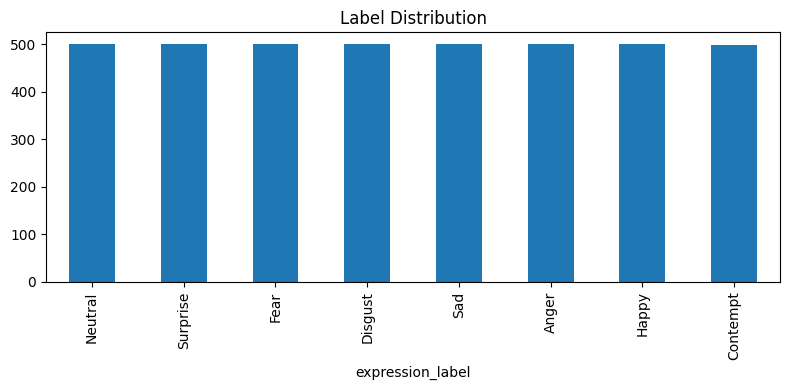

In [6]:
print(f'Total usable samples: {len(metadata_df):,}')
metadata_df['expression_label'].value_counts().plot(kind='bar', figsize=(8, 4), title='Label Distribution')
plt.tight_layout()
plt.show()


## Train / Validation / Test Split

The dataset ships with training and test annotations, but we create an explicit validation set for model selection. Adjust the split ratio or the stratification strategy if you are using a predefined partition.

In [7]:
train_df, holdout_df = train_test_split(
    metadata_df, test_size=0.2, stratify=metadata_df['expression'], random_state=SEED
)
val_df, test_df = train_test_split(
    holdout_df, test_size=0.5, stratify=holdout_df['expression'], random_state=SEED
)
print(f'Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}')


Train: 3199 | Val: 400 | Test: 400


## Data Module

Build a reusable tf.data pipeline with on-the-fly augmentation for the training split.

In [8]:
class AffectDataModule:
    "Prepares tf.data.Dataset objects for training, validation, and testing."

    def __init__(
        self,
        train_df: pd.DataFrame,
        val_df: pd.DataFrame,
        test_df: pd.DataFrame,
        image_size: Tuple[int, int] = IMAGE_SIZE,
        batch_size: int = BATCH_SIZE,
        augment: bool = True,
    ):
        self.splits = {
            'train': train_df.copy(),
            'val': val_df.copy(),
            'test': test_df.copy(),
        }
        self.image_size = image_size
        self.batch_size = batch_size
        self.augment = augment
        self.augmenter = tf.keras.Sequential(
            [
                tf.keras.layers.RandomFlip('horizontal'),
                tf.keras.layers.RandomRotation(0.1),
                tf.keras.layers.RandomZoom(0.1),
                tf.keras.layers.RandomBrightness(0.1),
            ],
            name='augmenter',
        )

    def _load_image(self, path: tf.Tensor) -> tf.Tensor:
        image_bytes = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image_bytes, channels=3)
        image = tf.image.resize(tf.cast(image, tf.float32), self.image_size)
        image = image / 255.0
        return image

    def _format_example(self, training: bool):
        def formatter(path, expr, val, aro):
            image = self._load_image(path)
            if training and self.augment:
                image = self.augmenter(image, training=True)
            targets = {
                'expression_head': tf.cast(expr, tf.int32),
                'valence_head': tf.cast(tf.expand_dims(val, -1), tf.float32),
                'arousal_head': tf.cast(tf.expand_dims(aro, -1), tf.float32),
            }
            return image, targets

        return formatter

    def get_dataset(self, split: str, with_labels: bool = True, training: bool = False) -> tf.data.Dataset:
        df = self.splits[split]
        paths = df['image_path'].astype(str).values
        expressions = df['expression'].astype(np.int32).values
        valence = df['valence'].astype(np.float32).values
        arousal = df['arousal'].astype(np.float32).values

        ds = tf.data.Dataset.from_tensor_slices((paths, expressions, valence, arousal))
        if training:
            ds = ds.shuffle(buffer_size=len(df), seed=SEED)
        if with_labels:
            ds = ds.map(self._format_example(training), num_parallel_calls=AUTOTUNE)
        else:
            def only_images(path, expr, val, aro):
                image, _ = self._format_example(False)(path, expr, val, aro)
                return image

            ds = ds.map(only_images, num_parallel_calls=AUTOTUNE)
        ds = ds.batch(self.batch_size).prefetch(AUTOTUNE)
        return ds

    def summary(self) -> pd.DataFrame:
        return pd.DataFrame({k: [len(v)] for k, v in self.splits.items()}, index=['num_samples']).T


In [9]:
data_module = AffectDataModule(train_df, val_df, test_df)
data_module.summary()


2025-09-27 14:34:23.266816: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-09-27 14:34:23.266985: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-09-27 14:34:23.266997: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-09-27 14:34:23.267157: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-27 14:34:23.267170: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


,num_samples
train,3199
val,400
test,400


## Model Factory

Create flexible Keras models that share a convolutional backbone and branch into three heads. The classification head predicts the discrete emotion, while two regression heads output valence and arousal scores in the range [-1, 1].

In [ ]:
BACKBONE_REGISTRY = {
    'mobilenet_v2': {
        'builder': tf.keras.applications.MobileNetV2,
        'preprocess': tf.keras.applications.mobilenet_v2.preprocess_input,
        'default_unfreeze': 100,
    },
    'resnet50': {
        'builder': tf.keras.applications.ResNet50,
        'preprocess': tf.keras.applications.resnet.preprocess_input,
        'default_unfreeze': 140,
    },
    'efficientnet_b0': {
        'builder': tf.keras.applications.EfficientNetB0,
        'preprocess': tf.keras.applications.efficientnet.preprocess_input,
        'default_unfreeze': 210,
    },
    'vgg16': {
        'builder': tf.keras.applications.VGG16,
        'preprocess': tf.keras.applications.vgg16.preprocess_input,
        'default_unfreeze': 15,
    },
}


@dataclass
class BaselineConfig:
    name: str
    backbone: str
    initial_epochs: int = 12
    fine_tune_epochs: int = 8
    learning_rate: float = 1e-4
    fine_tune_learning_rate: float = 1e-5
    dropout: float = 0.3
    loss_weights: Dict[str, float] | None = None
    freeze_base: bool = True
    fine_tune_at: Optional[int] = None

    def __post_init__(self):
        if self.loss_weights is None:
            self.loss_weights = {
                'expression_head': 1.0,
                'valence_head': 0.5,
                'arousal_head': 0.5,
            }
        if self.fine_tune_at is None:
            registry_entry = BACKBONE_REGISTRY.get(self.backbone)
            if registry_entry:
                self.fine_tune_at = registry_entry['default_unfreeze']


class ModelFactory:
    "Factory that builds and compiles the multitask Keras model."

    @staticmethod
    def build(config: BaselineConfig, image_size: Tuple[int, int] = IMAGE_SIZE) -> tf.keras.Model:
        entry = BACKBONE_REGISTRY[config.backbone]
        preprocess = entry['preprocess']
        backbone_fn = entry['builder']

        inputs = tf.keras.Input(shape=(*image_size, 3), name='image')
        x = tf.keras.layers.Lambda(lambda img: preprocess(img * 255.0), name='preprocess')(inputs)
        base_model = backbone_fn(include_top=False, input_tensor=x, weights='imagenet')
        base_model.trainable = not config.freeze_base

        features = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(base_model.output)
        features = tf.keras.layers.Dropout(config.dropout, name='feature_dropout')(features)
        features = tf.keras.layers.Dense(512, activation='relu', name='feature_projection')(features)
        features = tf.keras.layers.BatchNormalization(name='feature_norm')(features)

        expression_head = tf.keras.layers.Dense(
            NUM_CLASSES,
            activation='softmax',
            name='expression_head',
        )(features)
        valence_head = tf.keras.layers.Dense(1, activation='tanh', name='valence_head')(features)
        arousal_head = tf.keras.layers.Dense(1, activation='tanh', name='arousal_head')(features)

        model = tf.keras.Model(inputs=inputs, outputs=[expression_head, valence_head, arousal_head], name=f"{config.name}_model")

        losses = {
            'expression_head': tf.keras.losses.SparseCategoricalCrossentropy(),
            'valence_head': tf.keras.losses.MeanSquaredError(),
            'arousal_head': tf.keras.losses.MeanSquaredError(),
        }
        metrics = {
            'expression_head': [
                tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
                tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3'),
            ],
            'valence_head': [
                tf.keras.metrics.MeanAbsoluteError(name='mae'),
                tf.keras.metrics.RootMeanSquaredError(name='rmse'),
            ],
            'arousal_head': [
                tf.keras.metrics.MeanAbsoluteError(name='mae'),
                tf.keras.metrics.RootMeanSquaredError(name='rmse'),
            ],
        }

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
            loss=losses,
            loss_weights=config.loss_weights,
            metrics=metrics,
        )
        return model


## Experiment Runner

The runner encapsulates training (with optional fine-tuning), logging, and artifact management for each baseline.

In [11]:
class ExperimentRunner:
    def __init__(
        self,
        config: BaselineConfig,
        data_module: AffectDataModule,
        class_names: List[str],
        output_dir: Path = Path('experiments'),
    ):
        self.config = config
        self.data_module = data_module
        self.class_names = class_names
        self.output_dir = output_dir / config.name
        self.output_dir.mkdir(parents=True, exist_ok=True)
        self.history: Dict[str, List[float]] = {}
        self.model: Optional[tf.keras.Model] = None

    def _get_callbacks(self) -> List[tf.keras.callbacks.Callback]:
        checkpoint_path = self.output_dir / 'checkpoint.keras'
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_path,
                monitor='val_expression_head_accuracy',
                mode='max',
                save_best_only=True,
                save_weights_only=False,
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_expression_head_accuracy',
                mode='max',
                factor=0.5,
                patience=3,
                verbose=1,
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_expression_head_accuracy',
                mode='max',
                patience=5,
                restore_best_weights=True,
                verbose=1,
            ),
        ]
        return callbacks

    def _train_phase(self, epochs: int, fine_tune: bool = False) -> tf.keras.callbacks.History:
        train_ds = self.data_module.get_dataset('train', with_labels=True, training=True)
        val_ds = self.data_module.get_dataset('val', with_labels=True, training=False)
        callbacks = self._get_callbacks()
        history = self.model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1,
        )
        for key, values in history.history.items():
            self.history.setdefault(key, []).extend(values)
        phase = 'fine_tune' if fine_tune else 'initial'
        with open(self.output_dir / f'history_{phase}.json', 'w') as fp:
            json.dump(history.history, fp, indent=2)
        return history

    def run(self) -> Dict[str, object]:
        self.model = ModelFactory.build(self.config)
        self._train_phase(self.config.initial_epochs)

        if self.config.fine_tune_epochs > 0:
            base_layer_name = self.model.layers[1].name
            base_model = self.model.get_layer(base_layer_name)
            base_model.trainable = True
            if self.config.fine_tune_at is not None:
                for layer in base_model.layers[: self.config.fine_tune_at]:
                    layer.trainable = False
            self.model.compile(
                optimizer=tf.keras.optimizers.Adam(self.config.fine_tune_learning_rate),
                loss=self.model.loss,
                loss_weights=self.model.loss_weights,
                metrics=self.model.metrics,
            )
            self._train_phase(self.config.fine_tune_epochs, fine_tune=True)

        results_path = self.output_dir / 'training_log.json'
        with open(results_path, 'w') as fp:
            json.dump(self.history, fp, indent=2)

        return {
            'config': asdict(self.config),
            'history': self.history,
            'checkpoint_dir': str(self.output_dir),
        }



## Baseline Experiments

Configure at least two CNN backbones (e.g., MobileNetV2 and ResNet50). Feel free to adjust epochs, learning rates, or fine-tuning depth when running on your hardware.

In [12]:
baseline_setups = [
    BaselineConfig(name='MobileNetV2', backbone='mobilenet_v2', initial_epochs=10, fine_tune_epochs=6, learning_rate=2e-4, fine_tune_learning_rate=1e-5),
    BaselineConfig(name='ResNet50', backbone='resnet50', initial_epochs=10, fine_tune_epochs=6, learning_rate=1e-4, fine_tune_learning_rate=5e-6),
]

experiment_summaries = []
trained_models: Dict[str, tf.keras.Model] = {}

for config in baseline_setups:
    print(f"===== Running baseline: {config.name} ({config.backbone}) =====")
    runner = ExperimentRunner(config=config, data_module=data_module, class_names=CLASS_NAMES)
    summary = runner.run()
    experiment_summaries.append(summary)
    trained_models[config.name] = runner.model
    print(f"Completed {config.name}")

/var/folders/bq/lhhwtq996cvgk2b1gt041m080000gn/T/ipykernel_17085/1311879163.py:62: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = backbone_fn(include_top=False, input_tensor=x, weights='imagenet')


===== Running baseline: MobileNetV2 (mobilenet_v2) =====
Epoch 1/10


2025-09-27 14:34:24.970993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 354ms/step - arousal_head_loss: 0.5609 - arousal_head_mae: 0.6044 - arousal_head_rmse: 0.7489 - expression_head_accuracy: 0.1338 - expression_head_loss: 2.5269 - expression_head_top3: 0.3686 - loss: 3.1043 - valence_head_loss: 0.5938 - valence_head_mae: 0.6289 - valence_head_rmse: 0.7706 - val_arousal_head_loss: 0.5039 - val_arousal_head_mae: 0.5866 - val_arousal_head_rmse: 0.7091 - val_expression_head_accuracy: 0.1525 - val_expression_head_loss: 2.4738 - val_expression_head_top3: 0.3875 - val_loss: 3.2169 - val_valence_head_loss: 0.9973 - val_valence_head_mae: 0.8572 - val_valence_head_rmse: 0.9983 - learning_rate: 2.0000e-04
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 354ms/step - arousal_head_loss: 0.5609 - arousal_head_mae: 0.6044 - arousal_head_rmse: 0.7489 - expression_head_accuracy: 0.1338 - expression_head_loss: 2.5269 - expression_head_top3: 0.3686 - loss: 3.1043 - valence_head_loss: 0.5938 - valence_head_mae: 0.6289 - valence_head_rmse: 0.7706

AttributeError: 'Lambda' object has no attribute 'layers'

## Learning Curves

Plot metrics for each baseline to understand convergence behaviours and overfitting patterns.

In [ ]:
def plot_learning_curves(history: Dict[str, List[float]], metric_keys: List[str], title: str):
    plt.figure(figsize=(12, 4))
    for idx, key in enumerate(metric_keys, start=1):
        plt.subplot(1, len(metric_keys), idx)
        values = history.get(key)
        val_key = f"val_{key}"
        if not values:
            continue
        plt.plot(values, label=key)
        if val_key in history:
            plt.plot(history[val_key], label=val_key)
        plt.title(key)
        plt.xlabel('Epoch')
        plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

for summary in experiment_summaries:
    name = summary['config']['name']
    plot_learning_curves(summary['history'], ['expression_head_accuracy', 'valence_head_mae', 'arousal_head_mae'], title=f'{name} learning curves')


## Evaluation Utilities

Quantitative evaluation includes emotion classification accuracy/F1 plus regression MAE and RMSE for valence and arousal.

In [ ]:
def collect_predictions(model: tf.keras.Model, data_module: AffectDataModule, split: str) -> Dict[str, np.ndarray]:
    labeled_ds = data_module.get_dataset(split, with_labels=True, training=False)
    inference_ds = data_module.get_dataset(split, with_labels=False, training=False)
    predictions = model.predict(inference_ds, verbose=1)
    if isinstance(predictions, list):
        expr_pred, val_pred, aro_pred = predictions
    else:
        raise ValueError('Unexpected prediction output.')

    true_expr = []
    true_val = []
    true_aro = []
    for _, targets in labeled_ds.unbatch():
        true_expr.append(int(targets['expression_head'].numpy()))
        true_val.append(float(targets['valence_head'].numpy().squeeze()))
        true_aro.append(float(targets['arousal_head'].numpy().squeeze()))

    return {
        'true_expr': np.array(true_expr),
        'true_val': np.array(true_val),
        'true_aro': np.array(true_aro),
        'pred_expr': np.argmax(expr_pred, axis=1),
        'pred_expr_proba': expr_pred,
        'pred_val': val_pred.squeeze(),
        'pred_aro': aro_pred.squeeze(),
    }


def evaluate_split(model: tf.keras.Model, data_module: AffectDataModule, split: str, class_names: List[str]) -> Dict[str, float]:
    outputs = collect_predictions(model, data_module, split)
    metrics = {
        'accuracy': accuracy_score(outputs['true_expr'], outputs['pred_expr']),
        'macro_f1': f1_score(outputs['true_expr'], outputs['pred_expr'], average='macro'),
        'valence_mae': mean_absolute_error(outputs['true_val'], outputs['pred_val']),
        'valence_rmse': math.sqrt(mean_squared_error(outputs['true_val'], outputs['pred_val'])),
        'arousal_mae': mean_absolute_error(outputs['true_aro'], outputs['pred_aro']),
        'arousal_rmse': math.sqrt(mean_squared_error(outputs['true_aro'], outputs['pred_aro'])),
    }
    report = classification_report(outputs['true_expr'], outputs['pred_expr'], target_names=class_names, digits=4)
    metrics['classification_report'] = report
    cm = confusion_matrix(outputs['true_expr'], outputs['pred_expr'], normalize='true')
    metrics['confusion_matrix'] = cm.tolist()
    return metrics


def plot_confusion_matrix(cm: np.ndarray, class_names: List[str], title: str):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()


### Run Evaluation


In [ ]:
evaluation_records = []

for summary in experiment_summaries:
    name = summary['config']['name']
    model = trained_models[name]
    print(f"Evaluating {name} on validation set...")
    eval_metrics = evaluate_split(model, data_module, split='val', class_names=CLASS_NAMES)
    record = {
        'model': name,
        'accuracy': eval_metrics['accuracy'],
        'macro_f1': eval_metrics['macro_f1'],
        'valence_mae': eval_metrics['valence_mae'],
        'valence_rmse': eval_metrics['valence_rmse'],
        'arousal_mae': eval_metrics['arousal_mae'],
        'arousal_rmse': eval_metrics['arousal_rmse'],
    }
    evaluation_records.append(record)
    plot_confusion_matrix(np.array(eval_metrics['confusion_matrix']), CLASS_NAMES, title=f'{name} confusion matrix (val)')
    print(eval_metrics['classification_report'])

comparison_df = pd.DataFrame(evaluation_records)
comparison_df


## Qualitative Analysis

Visualise a mix of correctly and incorrectly predicted samples along with the predicted probabilities and regression outputs.

In [ ]:
def select_examples(df: pd.DataFrame, outputs: Dict[str, np.ndarray], correct: bool = True, k: int = 8) -> pd.DataFrame:
    matches = outputs['pred_expr'] == outputs['true_expr']
    idx = np.where(matches if correct else ~matches)[0]
    if len(idx) == 0:
        return pd.DataFrame()
    chosen = np.random.choice(idx, size=min(k, len(idx)), replace=False)
    subset = df.iloc[chosen].copy()
    subset['true_expr'] = outputs['true_expr'][chosen]
    subset['pred_expr'] = outputs['pred_expr'][chosen]
    subset['pred_conf'] = outputs['pred_expr_proba'][chosen, subset['pred_expr']]
    subset['true_val'] = outputs['true_val'][chosen]
    subset['pred_val'] = outputs['pred_val'][chosen]
    subset['true_aro'] = outputs['true_aro'][chosen]
    subset['pred_aro'] = outputs['pred_aro'][chosen]
    return subset


def visualize_examples(examples: pd.DataFrame, title: str):
    if examples.empty:
        print('No samples available for visualization.')
        return
    num_cols = 4
    num_rows = math.ceil(len(examples) / num_cols)
    plt.figure(figsize=(4 * num_cols, 4 * num_rows))
    for idx, (_, row) in enumerate(examples.iterrows()):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        image = tf.keras.utils.load_img(row['image_path'])
        plt.imshow(image)
        ax.axis('off')
        title_lines = [
            f"True: {CLASS_ID_TO_NAME[int(row['true_expr'])]}",
            f"Pred: {CLASS_ID_TO_NAME[int(row['pred_expr'])]} ({row['pred_conf']:.2f})",
            f"Valence: {row['true_val']:.2f} → {row['pred_val']:.2f}",
            f"Arousal: {row['true_aro']:.2f} → {row['pred_aro']:.2f}",
        ]
        ax.set_title(''.join(title_lines), fontsize=9)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# Example usage after evaluation
# outputs = collect_predictions(trained_models['MobileNetV2'], data_module, split='val')
# correct_samples = select_examples(val_df.reset_index(drop=True), outputs, correct=True, k=8)
# visualize_examples(correct_samples, 'Correct predictions - MobileNetV2')
# incorrect_samples = select_examples(val_df.reset_index(drop=True), outputs, correct=False, k=8)
# visualize_examples(incorrect_samples, 'Incorrect predictions - MobileNetV2')


## Landmark Visualisation (Optional)

Landmarks can help diagnose mispredictions. We keep a helper that overlays the 68 points on top of an image.

In [ ]:
def plot_landmarks(image_path: str, landmark_path: str):
    points = np.load(landmark_path)
    image = tf.keras.utils.load_img(image_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    if points.ndim == 1:
        points = points.reshape(-1, 2)
    plt.scatter(points[:, 0], points[:, 1], s=10, c='lime')
    plt.axis('off')
    plt.title('Facial landmarks')
    plt.show()

# Example usage:
# sample_row = metadata_df.sample(1).iloc[0]
# plot_landmarks(sample_row['image_path'], sample_row['landmarks_path'])


## Next Steps

- Experiment with additional backbones (EfficientNet, VGG) and hyperparameters.
- Add mixed-precision training or gradient accumulation when using GPUs.
- Log experiments to TensorBoard or Weights & Biases for deeper insight.
- Deploy the best-performing model for inference on unseen test data.